# Submission Information:

### Team Member 1:
* UNI:  WL2522
* Name: Wilson Lui (Team name: Handsome Machine Modeling School)

### Team Member 2 [optional]:
* UNI:  
* Name:

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

I experimented with treating the "month", "day_of_week", and "prev_days" features as both continuous and categorical. I also converted the "prev_days" feature into a categorical value of whether or not a person was ever called, due to how skewed the distribution was in favor of the value "999".

I decided to treat all three as continuous variables for the Logistic Regression model that I chose since it provided slightly better performance than when treaing them as categorical features.

In this step, the data is loaded and the categorical features are encoded as integers in preparation for one hot encoding.
Lastly, I create three balanced datasets using the following resampling methods:


1) Random Undersampling (rus)
2) SMOTE (sm)
3) SMOTE Edited Nearest Neighbors (enn)


In [36]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, scale, OneHotEncoder, MaxAbsScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif
from sklearn.svm import LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

data = pd.read_csv('data/data.csv')


In [37]:
#Separate the ID column from the holdout set


holdout = pd.read_csv('data/holdout.csv')
ID = holdout['ID']
holdout = holdout.drop('ID', 1)


#Remove the "duration" feature to avoid getting overoptimistic results


data = data.drop('duration', 1)
holdout = holdout.drop('duration', 1)


In [39]:
#Convert the "month" and "day_of_week" features to integers
#Convert the "prev_days" feature to a binary feature indicating whether a person has been contacted before


months = [('mar', 3), ('apr', 4), ('may', 5), ('jun', 6), ('jul', 7), ('aug', 8),
          ('sep', 9), ('oct', 10), ('nov', 11), ('dec', 12)]
weekdays = [('mon', 1), ('tue', 2), ('wed', 3), ('thu', 4), ('fri', 5)]

for month in months:
    data['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    holdout['month'].replace(to_replace=month[0], value=month[1], inplace=True)
    
for day in weekdays:
    data['day_of_week'].replace(to_replace=day[0], value=day[1], inplace=True)
    holdout['day_of_week'].replace(to_replace=day[0], value=day[1], inplace=True)
    

data['prev_days'] = np.where((data['prev_days']).astype(int) > 950, 0, 1)
holdout['prev_days'] = np.where((holdout['prev_days']).astype(int) > 950, 0, 1)


In [40]:
#Create a copy of the dataset for encoding purposes and leave the original for visualizations
#Separate the categorical features from the numerical ones
#Encode category and response variable strings to integers
#Treat "prev_days" as a categorical variable due to the large majority of 999 values


num = ['age', 'month', 'day_of_week', 'campaign', 'prev_contacts','emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

cat = ['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'prev_days', 'prev_outcomes']


enc_data = data.copy()
enc_holdout = holdout.copy()

le = LabelEncoder()


for col in cat:
    levels = np.concatenate((enc_data[col].unique(), enc_holdout[col].unique()))
    le.fit(levels)
    enc_data[col] = le.transform(enc_data[col])
    enc_holdout[col] = le.transform(enc_holdout[col])


In [41]:
#Encode the response variable
#Separate the features from the response variable


levels = enc_data['subscribed'].unique()
le.fit(levels)
enc_data['subscribed'] = le.transform(enc_data['subscribed'])

X = enc_data.iloc[:,:-1]
y = enc_data.iloc[:,-1]


In [6]:
#Balance the dataset using Random Undersampling, SMOTE, and SMOTE + Edited Nearest Neighbors
#Create a different train/test split for each balanced dataset


rus = RandomUnderSampler(replacement=True)
sm = SMOTE()
enn = SMOTEENN()

X_rus, y_rus = rus.fit_sample(X, y)
X_sm, y_sm = sm.fit_sample(X, y)
X_enn, y_enn = enn.fit_sample(X, y)

X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, stratify=y_rus)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, stratify=y_sm)
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, stratify=y_enn)


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

From the histograms of categorical features, I noticed that the "prev_days" feature was highly left-skewed, with a huge majority of the samples having a value of 999, meaning they were not previously contacted.
Also, I found that the "nr_employed", "euribor3m", and "emp_var_rate" features were highly correlated with each other, mostly likely due to the fact that all three are economic indicators.

In [48]:
#Get summary statistics on the data


data.describe()

,age,month,day_of_week,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,6.609317,2.982155,2.641639,0.037724,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.042670,1.408273,2.803230,0.190530,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,3.000000,1.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,5.000000,2.000000,1.000000,0.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,6.000000,3.000000,2.000000,0.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,8.000000,4.000000,3.000000,0.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,12.000000,5.000000,56.000000,1.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


Counter({'admin.': 8342, 'blue-collar': 7408, 'technician': 5371, 'services': 3168, 'management': 2340, 'retired': 1390, 'entrepreneur': 1198, 'self-employed': 1140, 'housemaid': 827, 'unemployed': 797, 'student': 708, 'unknown': 261})


([<matplotlib.axis.XTick at 0xbcdc470>,
 <a list of 12 Text xticklabel objects>)

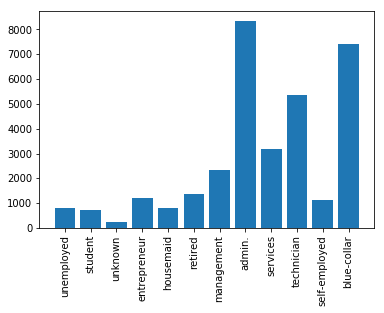

In [49]:
#Examine the distribution of job categories


job_count = Counter(data['job'])
print(job_count)
plt.bar(range(len(job_count)), job_count.values(), align='center')
plt.xticks(range(len(job_count)), list(job_count.keys()), rotation='vertical')


Counter({'married': 19955, 'single': 9256, 'divorced': 3676, 'unknown': 63})


([<matplotlib.axis.XTick at 0xc8da400>,
 <a list of 4 Text xticklabel objects>)

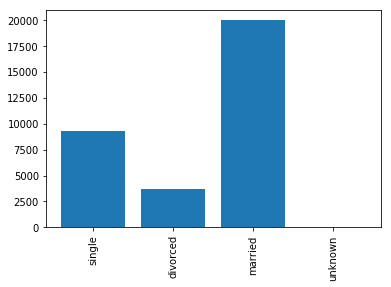

In [50]:
#Examine the distribution of marital statuses


marital_count = Counter(data['marital_status'])
print(marital_count)
plt.bar(range(len(marital_count)), marital_count.values(), align='center')
plt.xticks(range(len(marital_count)), list(marital_count.keys()), rotation='vertical')


Counter({'university.degree': 9760, 'high.school': 7580, 'basic.9y': 4889, 'professional.course': 4154, 'basic.4y': 3313, 'basic.6y': 1846, 'unknown': 1394, 'illiterate': 14})


([<matplotlib.axis.XTick at 0xc8918d0>,
 <a list of 8 Text xticklabel objects>)

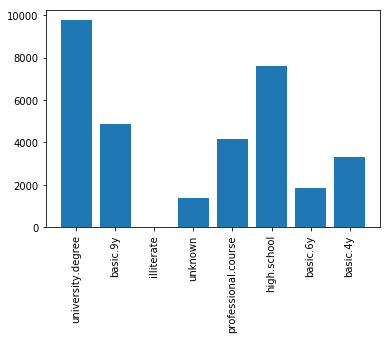

In [51]:
#Examine the distribution of education levels


education_count = Counter(data['education'])
print(education_count)
plt.bar(range(len(education_count)), education_count.values(), align='center')
plt.xticks(range(len(education_count)), list(education_count.keys()), rotation='vertical')


Counter({5: 11016, 7: 5716, 8: 4954, 6: 4272, 11: 3299, 4: 2097, 10: 540, 9: 465, 3: 437, 12: 154})


([<matplotlib.axis.XTick at 0xc8be748>,
 <a list of 10 Text xticklabel objects>)

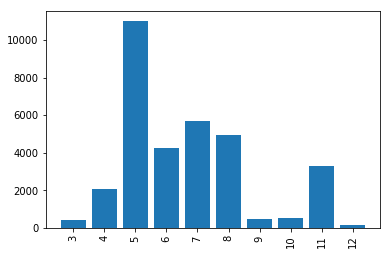

In [52]:
#Examine the distribution of call months


month_count = Counter(enc_data['month'])
print(month_count)
plt.bar(range(len(month_count)), month_count.values(), align='center')
plt.xticks(range(len(month_count)), list(month_count.keys()), rotation='vertical')


Counter({4: 6945, 1: 6749, 3: 6531, 2: 6495, 5: 6230})


([<matplotlib.axis.XTick at 0xe271f98>,
 <a list of 5 Text xticklabel objects>)

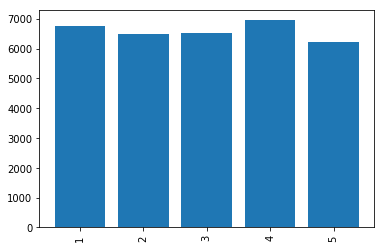

In [53]:
#Examine the distribution of days of the week


week_count = Counter(enc_data['day_of_week'])
print(week_count)
plt.bar(range(len(week_count)), week_count.values(), align='center')
plt.xticks(range(len(week_count)), list(week_count.keys()), rotation='vertical')


Counter({0: 31707, 1: 1243})


([<matplotlib.axis.XTick at 0xe3047f0>, <matplotlib.axis.XTick at 0xe31d2e8>],
 <a list of 2 Text xticklabel objects>)

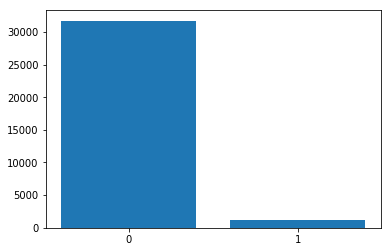

In [54]:
#Examine the distribution of previous days since last contact


days_count = Counter(data['prev_days'])
print(days_count)
plt.bar(range(len(days_count)), days_count.values(), align='center')
plt.xticks(range(len(days_count)), list(days_count.keys()))


Counter({'no': 26059, 'unknown': 6888, 'yes': 3})
Counter({'yes': 17176, 'no': 14974, 'unknown': 800})
Counter({'no': 27179, 'yes': 4971, 'unknown': 800})
Counter({'cellular': 20902, 'telephone': 12048})


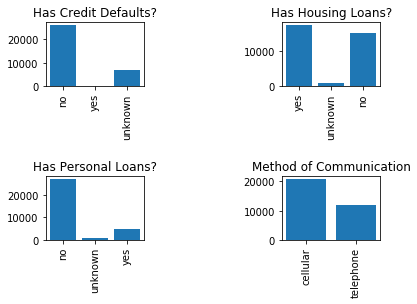

In [55]:
#Examine distribution of binary variables


default_count = Counter(data['credit_default'])
housing_count = Counter(data['housing'])
loan_count = Counter(data['loan'])
contact_count = Counter(data['contact'])
print(default_count)
print(housing_count)
print(loan_count)
print(contact_count)

ax1 = plt.subplot('331')
plt.bar(range(len(default_count)), default_count.values(), align='center')
plt.xticks(range(len(default_count)), list(default_count.keys()), rotation='vertical')
ax1.set_title('Has Credit Defaults?')

ax2 = plt.subplot('333')
plt.bar(range(len(housing_count)), housing_count.values(), align='center')
plt.xticks(range(len(housing_count)), list(housing_count.keys()), rotation='vertical')
ax2.set_title('Has Housing Loans?')

ax3 = plt.subplot('337')
plt.bar(range(len(loan_count)), loan_count.values(), align='center')
plt.xticks(range(len(loan_count)), list(loan_count.keys()), rotation='vertical')
ax3.set_title('Has Personal Loans?')

ax4 = plt.subplot('339')
plt.bar(range(len(contact_count)), contact_count.values(), align='center')
plt.xticks(range(len(contact_count)), list(contact_count), rotation='vertical')
ax4.set_title('Method of Communication')


Correlation Matrix
(nr_employed, euribor3m, emp_var_rate)


array([[ 1.        ,  0.9418152 ,  0.90294658],
       [ 0.9418152 ,  1.        ,  0.96852127],
       [ 0.90294658,  0.96852127,  1.        ]])

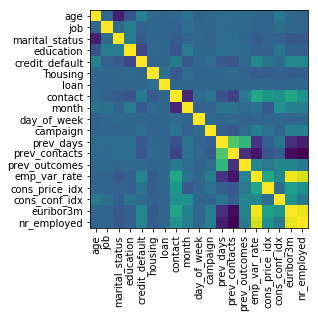

In [56]:
#Create covariance matrix heatmap to check for correlated features


cov = np.cov(scale(X), rowvar = False)
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(list(X))), list(X), rotation = 'vertical')
plt.yticks(range(len(list(X))), list(X))


#Take a closer look at the three continuous variables with high covariance


print('Correlation Matrix')
print('(nr_employed, euribor3m, emp_var_rate)')

np.corrcoef(np.stack((data['nr_employed'], data['euribor3m']), axis=0), data['emp_var_rate'])


# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

I used the following feature selection methods to help decide which features are candidates for removal:


1) Recursive Feature Selection with linear SVM
2) Recursive Feature Selection with Logistic Regression
3) SelectKBest with F-Scores
4) SelectKBest with Mutual Information
5) Stability Selection with Logistic Regression


Having performed these different feature selection methods, I decided to try dropping some features in varying combinations. In the end, I left out the "age", "job", and "housing" features due to them being deemed unimportant by almost every feature selection method. I decided to remove "nr_employed" due to its high correlation with "euribor3m" and "emp_var_rate", though I assume that removing one of the other two features instead would have a similar effect. Lastly, I dropped "cons_price_idx" and saw a less than 1% decrease in the roc_auc scores. Therefore, I decided to leave it out for the sake of having a simpler model. Removing "prev_days" seemed to cause a more significant decrease in roc_auc scores so I left it in my model. My final feature set includes the following features: 

"marital_status", "education", "credit_default", "loan", "contact", "month", "day_of_week", "campaign", "prev_days", "prev_contacts", "prev_outcomes", "emp_var_rate", "cons_conf_idx", "euribor3m"


I chose to avoid using SVM models due to the following reasons:


1) the requirement of providing probabilities for our predictions meant relying on SVC's probability parameter, which was not recommended in the lecture on linear models for classification
2) they did not exhibit significantly better performance than logistic regression models while requiring much longer to compute.


For each Logistic Regression model, I performed one hot encoding on the categorical variables, providing the number of categories that should be in each feature to account for rare categories that may be present in the training set but not in the test set. I used MaxAbsScaler() rather than StandardScaler() due to the sparsity of the encoded arrays.

Afterward, I tried using the same reduced feature set on an SGDClassifier and found that the results were slightly worse overall compared to the Logistic Regression model.


Mean roc_auc scores achieved with Logistic Regression using the reduced feature set on each balanced training set:


rus: 0.773443799587

sm : 0.847589670258

enn: 0.850619097685


roc_auc scores achieved with Logistic Regression using the reduced feature set on each balanced test set:


rus: 0.721087520023

sm : 0.762174914649

enn: 0.766552547537


Mean roc_auc scores achieved with the SGDClassifier using the reduced feature set on each balanced training set:


rus best score: 0.775891872894

sm  best score: 0.830834331782

enn best score: 0.835541548231


roc_auc scores achieved with the SGDClassifier using the reduced feature set on each balanced test set:


rus: 0.721444222657

sm : 0.756969852776

enn: 0.761043865103


In [57]:
#Determine feature importance with RFE using SVMs


svc = LinearSVC(random_state=5)
svc_rfe = RFE(svc, n_features_to_select = 10)

sm = svc_rfe.fit(X_train_sm, y_train_sm)
print('sm :', sm.ranking_)

rus = svc_rfe.fit(X_train_rus, y_train_rus)
print('rus:', rus.ranking_)

enn = svc_rfe.fit(X_train_enn, y_train_enn)
print('enn:', enn.ranking_)


sm : [10  4  1  1  1  8  1  1  5  7  1  1  6  1  3  2  1  1  9]
rus: [ 9  5  1  4  1 10  8  1  6  3  1  1  1  1  1  1  2  1  7]
enn: [ 9  7  1  1  1  8  1  1  5  1  1  1  4  1  6  2  3  1 10]


In [58]:
#Determine feature importance with RFE using Logistic Regression


lr = LogisticRegression(n_jobs=8, random_state=5)
lr_rfe = RFE(lr, n_features_to_select = 10)

sm_lr = lr_rfe.fit(X_train_sm, y_train_sm)
rus_lr = lr_rfe.fit(X_train_rus, y_train_rus)
enn_lr = lr_rfe.fit(X_train_enn, y_train_enn)

print('sm :', sm_lr.ranking_)
print('rus:', rus_lr.ranking_)
print('enn:', enn_lr.ranking_)


sm : [ 7  6  1  4  1 10  1  1  9  2  1  1  1  1  1  3  5  1  8]
rus: [ 7  6  1  4  1 10  1  1  9  2  1  1  1  1  1  3  5  1  8]
enn: [ 7  6  1  4  1 10  1  1  9  2  1  1  1  1  1  3  5  1  8]


In [59]:
#Determine feature importance with F-scores, mutual information, and SelectKBest


f = SelectKBest(f_classif, k=10)
mi = SelectKBest(mutual_info_classif, k=10)
                
f.fit(X_train_sm, y_train_sm)
mi.fit(X_train_sm, y_train_sm)

print('f :', f.get_support())
print('mi:', mi.get_support())


f : [False False False False  True False False  True False False  True  True
  True  True  True  True False  True  True]
mi: [ True  True  True  True False  True False False  True  True  True False
 False  True False False False False  True]


In [60]:
#Determine feature importance with stability selection using Logistic Regression


from sklearn.linear_model import RandomizedLogisticRegression

rlr = RandomizedLogisticRegression(random_state=5)

rus_rlr = rlr.fit(X_train_rus, y_train_rus)
sm_rlr = rlr.fit(X_train_sm, y_train_sm)
enn_rlr = rlr.fit(X_train_enn, y_train_enn)

print('sm :', sm_rlr.scores_)
print('rus:', rus_rlr.scores_)
print('enn:', enn_rlr.scores_)


sm : [ 0.     0.05   0.565  1.     1.     0.     0.445  1.     0.295  0.795  1.
  1.     0.14   1.     0.645  0.14   0.86   0.175  1.   ]
rus: [ 0.     0.05   0.565  1.     1.     0.     0.445  1.     0.295  0.795  1.
  1.     0.14   1.     0.645  0.14   0.86   0.175  1.   ]
enn: [ 0.     0.05   0.565  1.     1.     0.     0.445  1.     0.295  0.795  1.
  1.     0.14   1.     0.645  0.14   0.86   0.175  1.   ]


In [12]:
#Drop the features deemed to be unimportant: "age", "housing", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 5, 18]
leftover_discrete = np.array([0, 1, 2, 3, 4, 5, 9, 11])
levels = np.array([12, 4, 8, 3, 3, 2, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels),
                     MaxAbsScaler(), LogisticRegressionCV(n_jobs=8, random_state=5))

rus_score = cross_val_score(pipe, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.776213108323
sm : 0.852164664063
enn: 0.854274116656


In [8]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 18]
leftover_discrete = [0, 1, 2, 3, 4, 8, 10]
levels = np.array([4, 8, 3, 3, 2, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels),
                     MaxAbsScaler(), LogisticRegressionCV(n_jobs=8, random_state=5))

rus_score = cross_val_score(pipe, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.774256498017
sm : 0.842635497807
enn: 0.84470939061


In [9]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "cons_price_idx", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 8, 10]
levels = np.array([4, 8, 3, 3, 2, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels),
                     MaxAbsScaler(), LogisticRegressionCV(n_jobs=8, random_state=5))

rus_score = cross_val_score(pipe, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.774045043646
sm : 0.841655323521
enn: 0.843727817114


In [10]:
#Drop the features deemed to be unimportant: "age", "job", "housing", "prev_days", "cons_price_idx", "nr_employed"
#Perform One Hot Encoding on the categorical features
#Determine the best resampling technique to use with Logistic Regression


dropped = [0, 1, 5, 11, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 9]
levels = np.array([4, 8, 3, 3, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels),
                     MaxAbsScaler(), LogisticRegressionCV(n_jobs=8, random_state=5))

rus_score = cross_val_score(pipe, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
print('rus:', np.mean(rus_score))

sm_score = cross_val_score(pipe, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')
print('sm :', np.mean(sm_score))

enn_score = cross_val_score(pipe, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')
print('enn:', np.mean(enn_score))
    

rus: 0.774166656755
sm : 0.841575450234
enn: 0.843599847442


In [13]:
#Score the Logistic Regression model that produced the best results on the training data
#Drop the "age", "job", "housing", "cons_price_idx", and "nr_employed" features


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 8, 10]
levels = np.array([4, 8, 3, 3, 2, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

lr_pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels),
                     MaxAbsScaler(), LogisticRegressionCV(n_jobs=8, random_state=5))
    
rus_lr = pipe.fit(X_train_rus, y_train_rus)
rus_lr_score = roc_auc_score(rus_lr.predict(X_test_rus), y_test_rus)
print('rus:', rus_lr_score)

sm_lr = pipe.fit(X_train_sm, y_train_sm)
sm_lr_score = roc_auc_score(sm_lr.predict(X_test_sm), y_test_sm)
print('sm :', sm_lr_score)

enn_lr = pipe.fit(X_train_enn, y_train_enn)
enn_lr_score = roc_auc_score(enn_lr.predict(X_test_enn), y_test_enn)
print('enn:', enn_lr_score)


rus: 0.727100952058
sm : 0.769974471678
enn: 0.773054497085


In [15]:
#Find the optimal value of alpha to use with the SGDClassifier and the chosen feature set


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 8, 10]
levels = np.array([4, 8, 3, 3, 2, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})
one = OneHotEncoder(categorical_features=leftover_discrete, n_values=levels)

methods = [('rus', X_train_rus, y_train_rus),
           ('sm ', X_train_sm, y_train_sm),
           ('enn', X_train_enn, y_train_enn)]

for array in methods:  
    
    scaler = MaxAbsScaler()
    sgd = SGDClassifier(loss='modified_huber', n_jobs=8,
                  random_state=5,n_iter=np.ceil(10**6/np.shape(array[1])[0]))
    pipe = Pipeline([('Drop', drop), ('One Hot Encoder', one), ('MaxAbsScaler', scaler),
                    ('SGDClassifier', sgd)])
    
    grid = {'SGDClassifier__alpha': np.logspace(-1,7, 9)}
    
    gridsearch = GridSearchCV(pipe, param_grid=grid, scoring='roc_auc', cv=15, n_jobs=8)
    
    sgd = gridsearch.fit(array[1], array[2])
    print(array[0], 'best score:', sgd.score(array[1], array[2]))
    print(array[0], 'best parameters:', sgd.best_params_)
    

rus best score: 0.778961290502
rus best parameters: {'SGDClassifier__alpha': 0.10000000000000001}
sm  best score: 0.827943337382
sm  best parameters: {'SGDClassifier__alpha': 0.10000000000000001}
enn best score: 0.830239540355
enn best parameters: {'SGDClassifier__alpha': 0.10000000000000001}


In [16]:
#Score the SGDClassifier model with the optimal parameter value and the chosen feature set


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 8, 10]
levels = np.array([4, 8, 3, 3, 2, 2, 3])

sgd_pipe = make_pipeline(drop, OneHotEncoder(categorical_features=leftover_discrete, n_values=levels), 
                         MaxAbsScaler(),
                         SGDClassifier(alpha=sgd.best_params_['SGDClassifier__alpha'],
                                       loss='modified_huber', n_jobs=8, random_state=5, 
                                       n_iter=np.ceil(10**6/np.shape(array[1])[0])))

rus_sgd = sgd_pipe.fit(X_train_rus, y_train_rus)
rus_sgd_score = roc_auc_score(rus_sgd.predict(X_test_rus), y_test_rus)
print('rus:', rus_sgd_score)

sm_sgd = sgd_pipe.fit(X_train_sm, y_train_sm)
sm_sgd_score = roc_auc_score(sm_sgd.predict(X_test_sm), y_test_sm)
print('sm :', sm_sgd_score)

enn_sgd = sgd_pipe.fit(X_train_enn, y_train_enn)
enn_sgd_score = roc_auc_score(enn_sgd.predict(X_test_enn), y_test_enn)
print('enn:', enn_sgd_score)


rus: 0.724475745679
sm : 0.74574333025
enn: 0.748732573993


# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In this section, I tried using a single decision tree model, a random forest model, and an ExtraTreesClassifier model. I tried each model with both the full feature set and the reduced one that I used in step 2. I found that the results were either very close or the reduced feature set performed much worse. Therefore, I decided to use the full feature set for use with three models.


Mean roc_auc scores achieved with one Decision Tree on each balanced training set:


rus: 0.655539439416

sm : 0.895182311169

enn: 0.896686871576


roc_auc scores achieved with one Decision Tree on each balanced test_set:


rus: 0.916124713879

sm: 0.964969314802

enn: 0.899284923307


Mean roc_auc scores achieved with a Random Forest on each balanced training set:


rus: 0.979832158723

sm : 0.996729402728

enn: 0.999999991477


roc_auc scores achieved with a Random Forest on each balanced test_set:


rus: 0.92825020223

sm: 0.981237022125

enn: 0.945911511396


Mean roc_auc scores achieved with the ExtraTreesClassifier on each balanced training set:


rus: 0.979832158723

sm : 0.996729402728

enn: 0.999999991477


roc_auc scores achieved with the ExtraTreesClassifier on each balanced training set:


rus: 0.944855948244

sm: 0.983914240581

enn: 0.955509035091


In [17]:
#Perform a grid search to find the optimal Decision Tree parameter values for max_depth and max_features


grid = {'max_features': range(3, 15, 1), 'max_depth': np.linspace(5, 50, 2)}

search = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid = grid, scoring='roc_auc', cv=10, n_jobs=8)

rus = search.fit(X_train_rus, y_train_rus)
sm = search.fit(X_train_sm, y_train_sm)
enn = search.fit(X_train_enn, y_train_enn)

print('rus:', rus.score(X_train_rus, y_train_rus))
print(rus.best_params_)
print('sm :', sm.score(X_train_sm, y_train_sm))
print(sm.best_params_)
print('enn:', enn.score(X_train_enn, y_train_enn))
print(enn.best_params_)


rus: 0.905890804598
{'max_depth': 50.0, 'max_features': 12}
sm : 0.964976898472
{'max_depth': 50.0, 'max_features': 12}
enn: 1.0
{'max_depth': 50.0, 'max_features': 12}


In [18]:
#Perform cross-validation using each balanced dataset and the optimal parameter values


dt = DecisionTreeClassifier(max_features=enn.best_params_['max_features'],
                            max_depth=enn.best_params_['max_depth'], random_state=5)

print('rus:', np.mean(cross_val_score(dt, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')))
print('sm :', np.mean(cross_val_score(dt, X_train_sm, y_train_sm, cv=10, scoring='roc_auc')))
print('enn:', np.mean(cross_val_score(dt, X_train_enn, y_train_enn, cv=10, scoring='roc_auc')))


rus: 0.653203243857
sm : 0.89566066008
enn: 0.897558406325


In [19]:
#Score the test set using the chosen parameters values


rus_dt = dt.fit(X_train_rus, y_train_rus)
sm_dt = dt.fit(X_train_sm, y_train_sm)
enn_dt = dt.fit(X_train_enn, y_train_enn)

rus_dt_score = roc_auc_score(rus_dt.predict(X_test_rus), y_test_rus)
print('rus:', rus_dt_score)
sm_dt_score = roc_auc_score(sm_dt.predict(X_test_sm), y_test_sm)
print('sm:', sm_dt_score)
enn_dt_score = roc_auc_score(enn_dt.predict(X_test_enn), y_test_enn)
print('enn:', enn_dt_score)


rus: 0.9241176026
sm: 0.964285084435
enn: 0.902244894503


In [20]:
#Perform a grid search to find the optimal Random Forest parameter value for max_depth


grid = {'max_depth': np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None])}
search = GridSearchCV(RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs=8, random_state=5),
                      param_grid = grid, scoring='roc_auc', cv=10)


rus_rt = search.fit(X_train_rus, y_train_rus)
sm_rt = search.fit(X_train_sm, y_train_sm)
enn_rt = search.fit(X_train_enn, y_train_enn)

print('rus:', rus_rt.score(X_train_rus, y_train_rus))
print(rus_rt.best_params_)
print('sm :', sm_rt.score(X_train_sm, y_train_sm))
print(sm_rt.best_params_)
print('enn:', enn_rt.score(X_train_enn, y_train_enn))
print(enn_rt.best_params_)


rus: 0.978771409801
{'max_depth': 40}
sm : 0.99685931708
{'max_depth': 40}
enn: 0.999999978759
{'max_depth': 40}


In [21]:
#Score the test set using the chosen parameter


rt = RandomForestClassifier(n_estimators=75, max_features='sqrt',
                            max_depth=enn_rt.best_params_['max_depth'], n_jobs=8, random_state=5)

rus_rt = rt.fit(X_train_rus, y_train_rus)
sm_rt = rt.fit(X_train_sm, y_train_sm)
enn_rt = rt.fit(X_train_enn, y_train_enn)

rus_rt_score = roc_auc_score(rus_rt.predict(X_test_rus), y_test_rus)
print('rus:', rus_rt_score)
sm_rt_score = roc_auc_score(sm_rt.predict(X_test_sm), y_test_sm)
print('sm:', sm_rt_score)
enn_rt_score = roc_auc_score(enn_rt.predict(X_test_enn), y_test_enn)
print('enn:', enn_rt_score)


rus: 0.932922542517
sm: 0.98262245828
enn: 0.947696523313


In [81]:
#Perform a grid search to find the optimal Extra Trees parameter value for max_depth


grid = {'max_depth': np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None])}
et_search = GridSearchCV(ExtraTreesClassifier(n_estimators=50, max_features='sqrt', n_jobs=8, random_state=5),
                      param_grid = grid, scoring='roc_auc', cv=10)


rus_et = et_search.fit(X_train_rus, y_train_rus)
sm_et = et_search.fit(X_train_sm, y_train_sm)
enn_et = et_search.fit(X_train_enn, y_train_enn)

print('rus:', rus_et.score(X_train_rus, y_train_rus))
print(rus_et.best_params_)
print('sm :', sm_et.score(X_train_sm, y_train_sm))
print(sm_et.best_params_)
print('enn:', enn_et.score(X_train_enn, y_train_enn))
print(enn_et.best_params_)


rus: 0.993210252139
{'max_depth': None}
sm : 0.998726369149
{'max_depth': None}
enn: 1.0
{'max_depth': None}


In [82]:
#Score the test set using the chosen parameter


et = ExtraTreesClassifier(n_estimators=75, max_features='sqrt',
                          max_depth=enn_et.best_params_['max_depth'], n_jobs=8, random_state=5)

rus_et = et.fit(X_train_rus, y_train_rus)
sm_et = et.fit(X_train_sm, y_train_sm)
enn_et = et.fit(X_train_enn, y_train_enn)

rus_et_score = roc_auc_score(rus_et.predict(X_test_rus), y_test_rus)
print('rus:', rus_et_score)
sm_et_score = roc_auc_score(sm_et.predict(X_test_sm), y_test_sm)
print('sm :', sm_et_score)
enn_et_score = roc_auc_score(enn_et.predict(X_test_enn), y_test_enn)
print('enn:', enn_et_score)


rus: 0.950548831973
sm : 0.984604295945
enn: 0.95665368955


# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

Here, I performed poor man's stacking with an ensemble made up of the previously chosen models and weighted them relative to their roc_auc test scores.

I then tried training an EasyEnsemble AdaBoost classifier and adding it to the ensemble.


In [85]:
#Trying out EasyEnsemble with AdaBoost

from imblearn.ensemble import EasyEnsemble
from sklearn.ensemble import AdaBoostClassifier

ee = EasyEnsemble(random_state=5)

learners = list()

X_ee, y_ee = ee.fit_sample(X, y)

X_train_ee, X_test_ee, y_train_ee, y_test_ee = train_test_split(X_ee, y_ee)
grid = {'n_estimators': [50, 75, 100]}
ee_search = GridSearchCV(AdaBoostClassifier(random_state=5), param_grid = grid, scoring='roc_auc', cv=10)

#for i in range(0, np.shape(X_train_ee)[0]):
#    ee_search.fit(X_train_ee[i], y_train_ee[i])
#    print(i, ee_search.score(X_train_ee[i], y_train_ee[i]))
#    print(ee_search.best_params_)


0 0.811986172525
{'n_estimators': 100}
1 0.799541713792
{'n_estimators': 50}
2 0.801207588912
{'n_estimators': 50}
3 0.80936187853
{'n_estimators': 75}
4 0.801291122164
{'n_estimators': 50}
5 0.809419938132
{'n_estimators': 100}
6 0.806043518284
{'n_estimators': 50}


In [86]:
#Score the EasyEnsemble classifier
#Set the "n_estimators" parameter to be approximately the average of the optimal values returned by GridSearchCV


ada = AdaBoostClassifier(n_estimators=75, random_state=5)

for i in range(0, np.shape(X_train_ee)[0]):
    learner = ada.fit(X_train_ee[i], y_train_ee[i])    
    print(i, np.mean(cross_val_score(search, X_train_ee[i], y_train_ee[i], cv=5, scoring='roc_auc')))
    learners.append((i, learner))

ada_vc.fit(X_train_sm, y_train_sm)

roc_auc_score(ada_vc.predict(X_test_sm), y_test_sm)


0 0.787387699148
1 0.778863615482
2 0.785396298063
3 0.78531016532
4 0.784622033773
5 0.783161288744
6 0.789590723288


0.90923961797301167

In [88]:
#Calibrate the selected classifiers and fit them to the test set


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])

sm_lr_cal = CalibratedClassifierCV(base_estimator=sm_lr, method='isotonic', cv='prefit')
sm_lr_cal.fit(X_test_sm, y_test_sm)

sm_sgd_cal = CalibratedClassifierCV(base_estimator=sm_sgd, method='isotonic', cv='prefit')
sm_sgd_cal.fit(X_test_sm, y_test_sm)

sm_dt_cal = CalibratedClassifierCV(base_estimator=sm_dt, method='isotonic', cv='prefit')
sm_dt_cal.fit(X_test_sm, y_test_sm)

sm_rt_cal = CalibratedClassifierCV(base_estimator=sm_rt, method='isotonic', cv='prefit')
sm_rt_cal.fit(X_test_sm, y_test_sm)

sm_et_cal = CalibratedClassifierCV(base_estimator=sm_rt, method='isotonic', cv='prefit')
sm_et_cal.fit(X_test_sm, y_test_sm)

ada_vc_cal = CalibratedClassifierCV(base_estimator=ada_vc, method='isotonic', cv='prefit')
ada_vc_cal.fit(X_test_sm, y_test_sm)


CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[(0, AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=5)), (1, AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=5)), (2, AdaBoostClassifier(algorit...ithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=5))],
         n_jobs=8, voting='soft', weights=None),
            cv='prefit', method='isotonic')

In [89]:
#Testing an ensemble with the EasyEnsemble/AdaBoost classifier included


dropped = [0, 1, 5, 15, 18]
leftover_discrete = [0, 1, 2, 3, 4, 10]
levels = np.array([4, 8, 3, 3, 2, 3])
drop = FunctionTransformer(np.delete, kw_args={'obj': dropped, 'axis': 1})

vc = VotingClassifier(estimators= [('ada_vc', ada_vc), ('sm_lr', sm_lr), ('sm_sgd', sm_sgd), ('sm_dt', sm_dt), ('sm_rt', sm_rt), ('sm_et', sm_et)],
                      voting='soft', weights=[2, 2, 1, 2, 16, 16], n_jobs=8)

vc.fit(X_train_sm, y_train_sm)
final_score = np.mean(cross_val_score(vc, X_train_sm, y_train_sm, cv=10, scoring='roc_auc'))

print(final_score)

assert final_score > 0.89


0.985900236163


In [90]:
#Generate the prediction probabilities for the holdout set and export them


probs = (vc.predict_proba(enc_holdout.as_matrix()))
print(probs)
predictions = np.stack((ID, np.fmin(probs[:,0], probs[:,1])), axis=1)
header = np.array([['ID', 'Subscribed']])

predictions = np.append(header, predictions, axis=0)
print(predictions)
np.savetxt("predictions.csv", predictions, delimiter=',', fmt='%s')


[[ 0.95782183  0.04217817]
 [ 0.9510838   0.0489162 ]
 [ 0.86611494  0.13388506]
 ..., 
 [ 0.71567245  0.28432755]
 [ 0.85848186  0.14151814]
 [ 0.85625421  0.14374579]]
[['ID' 'Subscribed']
 ['2866.0' '0.04217817328771373']
 ['1957.0' '0.048916203547115164']
 ..., 
 ['4196.0' '0.28432755216521993']
 ['2999.0' '0.1415181392930592']
 ['1642.0' '0.14374578620949277']]
